## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [37]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import IPython.display as ipd

import sys
sys.path.append('hifigan/')
import numpy as np
import torch
import librosa
import librosa.display
import math
import json
import os
import time

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence, symbol_to_id
from text.cleaners import transliteration_ua_cleaners, english_cleaners, transliteration_cleaners,transliteration_cleaners_with_stress
from text.rudict import RuDict

import torch.nn.utils.prune as prune
from torch.nn import functional as F

from sklearn.metrics.pairwise import cosine_similarity as cs


from hifigan.meldataset import MAX_WAV_VALUE
from hifigan.models import Generator
from hifigan.env import AttrDict

from audio_processing import get_mel

loaded = False



In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower', 
                       interpolation='none')
    plt.savefig('out.png')
    ipd.display(ipd.Image('out.png'))

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 22050
# hparams.end_symbols_ids = [symbol_to_id[s] for s in '?!.']
# hparams.use_gst = False

In [114]:
checkpoint_path = "weights/checkpoint_200k_44ktp_natasha"
model = Tacotron2(hparams)
model.load_state_dict(torch.load(checkpoint_path,map_location=torch.device('cpu'))['state_dict'])
_ = model.cpu().eval()#.half()

In [4]:
ref_mel = get_mel('test/test2.wav', hparams).type(torch.HalfTensor).cuda()
print(ref_mel.dtype, ref_mel.shape)

NameError: name 'hparams' is not defined

In [148]:
print(ref_mel)

tensor([[[-3.2363, -2.8613, -2.9082,  ..., -2.1523, -2.1094, -2.0898],
         [-4.6133, -4.9492, -5.1523,  ..., -4.4961, -4.4922, -4.4805],
         [-7.0156, -6.4062, -6.4336,  ..., -6.4727, -6.5977, -7.1055],
         ...,
         [-9.5312, -9.2891, -9.2969,  ..., -9.3516, -9.2422, -9.4922],
         [-9.4922, -9.6328, -9.5547,  ..., -9.7109, -9.5312, -9.4297],
         [-9.6328, -9.5938, -9.2422,  ..., -9.6406, -9.6172, -9.5938]]],
       device='cuda:0', dtype=torch.float16)


In [47]:

text = "Тетрагидропиранилциклопентилтетрагидропиридопиридиновые вещества".lower()
text = "Мин+истр здравоохран+ения улет+ел. И обещ+ал верн+уться. С вакц+инами. Нав+ерно, +есть как+ой-то м+ир, где мин+истрам л+ично н+адо лет+ать за вакц+инами с четырьм+я перес+адками во вр+емя эпид+емии. М+ожет по+этому в Зимб+абве уже вакцин+ируют, потом+у чт+о их мин+истр л+ично с+ел на слон+а и по+ехал на нем в больш+ой г+ород преклон+ить кол+ено и получ+ить вакц+ину? Так+ой м+ир нам пыт+аются прод+ать?".lower()
# text = "Вс+е смеш+алось в д+оме Обл+онских. Жен+а узн+ала, что муж был в св+язи с б+ывшею в их д+оме франц+уженкою-гуверн+анткой, и объяв+ила м+ужу, что не м+ожет ж+ить с ним в одн+ом д+оме. Полож+ение это продолж+алось уже третий д+ень и муч+ительно ч+увствовалось и сам+ими супр+угами, и вс+еми чл+енами семь+и, и домоч+адцами."
# text = "Тв+орог или твор+ог, к+озлы или козл+ы, з+амок или зам+ок.".lower()
# text="мн+е хот+елось б+ы? сказ+ать к+ак я призн+ателен вс+ем прис+утсвующим сд+есь."
# text = "tak+oi m+ir n+am pyt+aiutsia prod+at'?"
text = "Как пройти в дом?"
# text = "В+ыйду,,,,,,, н+очью,,, в п+оле,,, с кон+ем"
text = "Н+очь, +улица, фон+арь, апт+ека. Бессм+ысленный, и т+усклый св+ет. Жив+и ещ+е х+оть ч+етверть в+ека - Вс+ё б+удет т+ак. Исх+ода н+ет."
# text = "Ночь, улица, фонарь, аптека. Бессмысленный, и тусклый свет. Жив+и еще хоть четверть века - Все будет так. Исхода нет."
# text = "Игра - тип осмысленной непродуктивной деятельности, где мотив лежит не в её результате, а в самом процессе. Также термин игра используют для обозначения набора предметов или программ, предназначенных для подобной деятельности."
# text = "Прижм+ись к+о мн+е кр+епче и бл+иже. Не ж+ил я,, блужд+ал ср+едь чуж+их. О с+он м+ой,, Я н+овое в+ижу, В бред+у поцел+уев тво+их!"

# text = "Тогд+а почем+у ж+е я ощущ+аю себ+я н+а гр+ани физ+ической катастр+офы?"
# text ="Ты согласен?"
# text = "Здр+аствуйте, мен+я зов+ут Андр+ей Никиш+аев, я с+иньер архит+ектор в комп+ании манив+ео. П+о мо+им д+анным у в+ас не закр+ытый кред+ит на с+умму в+осемдесят тр+и т+ысячи тр+иста шестдес+ят тр+и гр+ивны. Н+ужно погас+ить!"
# text = "С к+аждым дн+ем весн+ы стан+овится вс+е тепл+ее, а +это р+адость для к+аждого вод+ителя."
# text = "Молод+ой парн+ишка Т+анг С+ан одн+ажды оступ+ился и сл+едуя сво+им жел+аниям и пр+ихотям вор+ует секр+етные уч+ения в своей школе боевых искусств."

print(transliteration_cleaners_with_stress(text))
sequence = np.array(text_to_sequence(text, ['transliteration_cleaners_with_stress']))[None, :]
print(sequence)
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cpu().long()

Sn+och', +ulitsa, fon+ar', apt+eka. bessm+yslennyi, i t+usklyi sv+et. zhiv+i eshch+e kh+ot' ch+etvert' v+eka - vs+io b+udet t+ak. iskh+oda n+et.E
[[12 27 40 28 16 21  3  6 11 40 34 25 22 33 32 14  6 11 19 28 27 40 14 31
   3  6 11 14 29 33 40 18 24 14  7 11 15 18 32 32 26 40 38 32 25 18 27 27
  38 22  6 11 22 11 33 40 34 32 24 25 38 22 11 32 35 40 18 33  7 11 39 21
  22 35 40 22 11 18 32 21 16 21 40 18 11 24 21 40 28 33  3 11 16 21 40 18
  33 35 18 31 33  3 11 35 40 18 24 14 11  1 11 35 32 40 22 28 11 15 40 34
  17 18 33 11 33 40 14 24  7 11 22 32 24 21 40 28 17 14 11 27 40 18 33  7
  13]]


In [48]:
def model_size(model):
    torch.save(model.state_dict(), "temp.p")
    size = ('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')
    return size

In [115]:


bit8_model = torch.quantization.quantize_dynamic(
        model, {torch.nn.LSTM, torch.nn.Linear, torch.nn.LSTMCell, torch.nn.GRUCell}, dtype=torch.qint8
)

print(model_size(bit8_model))
for name, module in bit8_model.named_modules():
    if isinstance(module, torch.nn.Conv1d):
        prune.l1_unstructured(module, name='weight', amount=0.2)
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module, name='weight', amount=0.2)
   
print(model_size(bit8_model))

('Size (MB):', 59.99204)
Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
Conv1d(2, 32, kernel_size=(31,), stride=(1,), padding=(15,), bias=False)
Conv1d(80, 512, kernel_size=(5,), stride=(1,), padding=(2,))
Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
Conv1d(512, 80, kernel_size=(5,), stride=(1,), padding=(2,))
Conv1d(512, 256, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
('Size (MB):', 94.671951)


In [121]:
%%time
# np.random.seed(16)


_, mel_outputs, mel_outputs_postnet, _, alignments, emb2 = bit8_model.inference(sequence,seed=None, token_idx=0)

RuntimeError: No CUDA GPUs are available

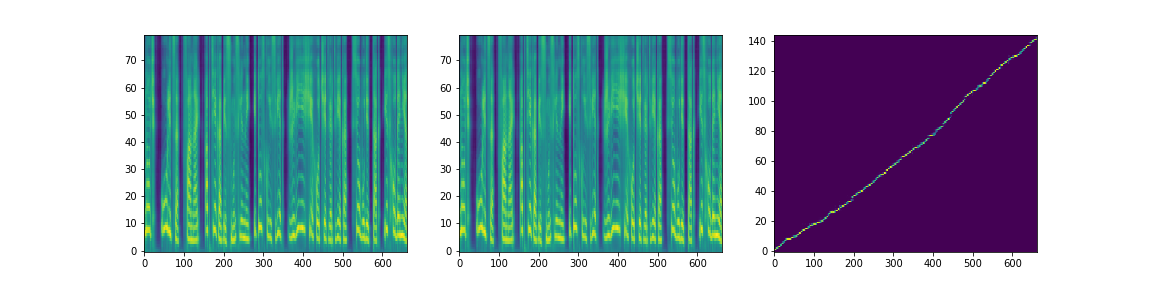

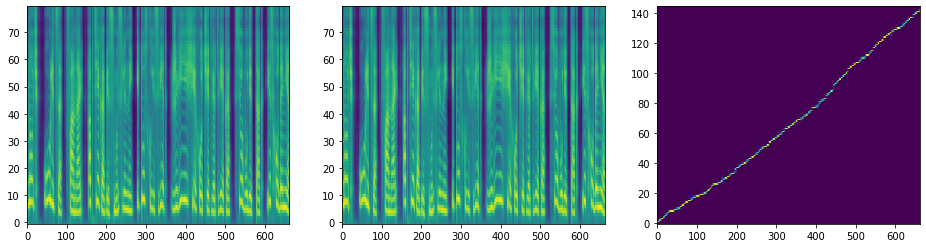

In [120]:
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

In [85]:
loaded = False
def load_checkpoint(filepath, device):
    assert os.path.isfile(filepath)
    print("Loading '{}'".format(filepath))
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Complete.")
    return checkpoint_dict

if not loaded:
    device = torch.device('cpu')
    with open('hifigan/config.json') as fp:
        json_config = json.load(fp)
        h = AttrDict(json_config)
    generator = Generator(h).to(device)

    state_dict_g = load_checkpoint("hifigan/g_02500000", device)
    generator.load_state_dict(state_dict_g['generator'])
    generator.eval()
    generator.remove_weight_norm()
    print(generator)
    
#     generator = torch.quantization.quantize_dynamic(
#         generator, {torch.nn.LSTM, torch.nn.Linear, torch.nn.LSTMCell, torch.nn.GRUCell}, dtype=torch.qint8
#     )
    loaded=True

def inference(mel, generator):
    

    
    with torch.no_grad():
        y_g_hat = generator(mel)
        audio = y_g_hat.squeeze()
        audio = audio * MAX_WAV_VALUE
        audio = audio.detach().cpu().numpy()#.astype('int16')

        return audio
    


Loading 'hifigan/g_02500000'
Complete.
Removing weight norm...
Generator(
  (conv_pre): Conv1d(80, 512, kernel_size=(7,), stride=(1,), padding=(3,))
  (ups): ModuleList(
    (0): ConvTranspose1d(512, 256, kernel_size=(16,), stride=(8,), padding=(4,))
    (1): ConvTranspose1d(256, 128, kernel_size=(16,), stride=(8,), padding=(4,))
    (2): ConvTranspose1d(128, 64, kernel_size=(4,), stride=(2,), padding=(1,))
    (3): ConvTranspose1d(64, 32, kernel_size=(4,), stride=(2,), padding=(1,))
  )
  (resblocks): ModuleList(
    (0): ResBlock1(
      (convs1): ModuleList(
        (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(3,), dilation=(3,))
        (2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(5,), dilation=(5,))
      )
      (convs2): ModuleList(
        (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), paddi

In [86]:
s = time.perf_counter()
mel = mel_outputs_postnet.type(torch.float32)
print(time.perf_counter()-s)
            

0.00018203800027549732


In [87]:
%%time
audio = inference(mel, generator)
ipd.Audio(audio, rate=hparams.sampling_rate)  

CPU times: user 17.3 s, sys: 251 ms, total: 17.5 s
Wall time: 3.47 s


In [81]:
# style vectors similarity
vect = model.gst.stl.embed

In [ ]:
norm = F.normalize(vect, dim=1).detach().cpu().numpy()
res =  cs(norm, norm)
res

In [ ]:
(emb1.detach().cpu().numpy()[0][0] - emb2.detach().cpu().numpy()[0][0])

In [ ]:
print(emb1.detach().cpu().numpy().shape)